# 🎯 Object Tracking Pipeline Tutorial

This notebook demonstrates how to:
1. **Detect objects** in video using OWLv2 (just by describing them in text!)
2. **Segment objects** precisely using SAM2
3. **Track objects** through video frames using Cutie

---

### 🌟 Why this is powerful?
- No manual annotation needed – just describe what you want to track
- Works with cars, people, animals, sports equipment, etc.
- Handles occlusion and movement in video



## 📚 Installed Libraries

- **transformers** → OWLv2 object detection  
- **sam2** → Precise object segmentation  
- **opencv-python** → Video processing  
- **pillow** → Image handling  
- **matplotlib** → Visualization  

**Models we’ll use:**
- **OWLv2** → Detects *any* object from text prompts  
- **SAM2** → Produces pixel-perfect masks  
- **Cutie** → Tracks objects across video frames  


In [3]:
# ====== STEP 1: Install All Required Libraries ======
print("📦 Installing all dependencies...")
print("This will take a few minutes on first run...")

!pip install -q transformers timm torchvision huggingface_hub pillow opencv-python matplotlib
!pip install -q git+https://github.com/facebookresearch/sam2.git

print("✅ All libraries installed successfully!")


📦 Installing all dependencies...
This will take a few minutes on first run...
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
✅ All libraries installed successfully!


## 💾 Accessing Videos

Upload your video to Google Drive and set the path:  
`/content/drive/MyDrive/your-video.mp4`

Or upload directly to Colab and update the path.


In [4]:
# ====== STEP 2: Mount Google Drive (if using video from Drive) ======
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
print("✓ Google Drive mounted - you can now access your videos!")


Mounted at /content/drive
✓ Google Drive mounted - you can now access your videos!


## 🔧 GPU / CPU Setup

We’ll check if GPU is available for faster processing.  
If not, the pipeline still works fine on CPU (just slower).


In [5]:
# ====== STEP 3: Import All Required Libraries ======
print("📚 Importing all necessary libraries...")

import torch
import os
import shutil
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from IPython.display import HTML, display, Video
from base64 import b64encode
import sys

print("✓ Basic libraries imported")


📚 Importing all necessary libraries...
✓ Basic libraries imported


In [6]:
# Check if GPU is available
if torch.cuda.is_available():
    try:
        torch.cuda.init()
        print('🚀 GPU detected and ready! Processing will be fast.')
        device = 'cuda'
        use_cuda = True
    except:
        print('⚠️ GPU detected but not properly configured. Using CPU instead.')
        device = 'cpu'
        use_cuda = False
else:
    print('💻 Using CPU - processing will be slower but still works!')
    device = 'cpu'
    use_cuda = False


🚀 GPU detected and ready! Processing will be fast.


## 🤖 Setting Up Cutie

Cutie is responsible for tracking objects consistently across frames.  
We’ll clone the repo, install it, and download pre-trained weights.


In [7]:
print("🔧 Setting up Cutie tracking model...")

# Navigate to content directory and clean up
os.chdir('/content')

# Remove any existing Cutie installation
if os.path.exists('/content/Cutie'):
    try:
        shutil.rmtree('/content/Cutie')
        print("✓ Cleaned up previous Cutie installation")
    except:
        os.system('rm -rf /content/Cutie')
        print("✓ Force cleaned previous installation")

# Download Cutie from GitHub
print("📥 Downloading Cutie from GitHub...")
!git clone https://github.com/hkchengrex/Cutie.git

# Install Cutie
os.chdir('/content/Cutie')
!python -m pip install -e .

# Download pre-trained model weights
print("⬇️ Downloading pre-trained tracking weights...")
!python cutie/utils/download_models.py

print("✅ Cutie setup complete!")


🔧 Setting up Cutie tracking model...
📥 Downloading Cutie from GitHub...
Cloning into 'Cutie'...
remote: Enumerating objects: 609, done.
remote: Counting objects: 100% (238/238), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 609 (delta 199), reused 165 (delta 165), pack-reused 371 (from 1)
Receiving objects: 100% (609/609), 2.81 MiB | 11.24 MiB/s, done.
Resolving deltas: 100% (308/308), done.
Obtaining file:///content/Cutie
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Cloning https://github.com/cheind/py-thin-plate-spline to /tmp/pip-install-62_uoij4/thinplate_97dffb66fd464706835f30b54780f26d
  Running command git clone --filter=blob:none --quiet https://github.com/cheind/py-thin-plate-spline /tmp/pip-install-62_uoij4/thinplate_97dffb66fd464706835f30b54780f26d

## 🧠 Loading Models

We’ll now load:  
1. **OWLv2** → Object detection (from text)  
2. **SAM2** → Segmentation (pixel masks)  
3. **Cutie** → Tracking (identity persistence)


In [8]:
print("🧠 Loading AI models... (this takes a moment)")

# Import model classes
from transformers import Owlv2Processor, Owlv2ForObjectDetection
from sam2.sam2_image_predictor import SAM2ImagePredictor

# Cutie imports
from omegaconf import DictConfig, open_dict
from hydra import compose, initialize_config_dir
from hydra.core.global_hydra import GlobalHydra
from cutie.model.cutie import CUTIE
from cutie.inference.inference_core import InferenceCore
from cutie.inference.utils.args_utils import get_dataset_cfg
from gui.interactive_utils import image_to_torch, torch_prob_to_numpy_mask, index_numpy_to_one_hot_torch, overlay_davis

print("✓ All imports successful")

# Load OWLv2 (Object Detection)
print("Loading OWLv2 object detection model...")
owl_processor = Owlv2Processor.from_pretrained("google/owlv2-base-patch16-ensemble")
owl_model = Owlv2ForObjectDetection.from_pretrained("google/owlv2-base-patch16-ensemble")
print("✅ OWLv2 ready - can detect objects from text descriptions!")

# Load SAM2 (Segmentation)
print("Loading SAM2 segmentation model...")
sam2_predictor = SAM2ImagePredictor.from_pretrained("facebook/sam2-hiera-large")
print("✅ SAM2 ready - can create pixel-perfect object masks!")

# Load Cutie (Tracking)
print("Loading Cutie tracking model...")
with torch.inference_mode():
    GlobalHydra.instance().clear()
    config_dir = "/content/Cutie/cutie/config"
    initialize_config_dir(config_dir=config_dir, version_base='1.3.2', job_name="eval_config")
    cfg = compose(config_name="eval_config")

    with open_dict(cfg):
        cfg['weights'] = '/content/Cutie/weights/cutie-base-mega.pth'

    data_cfg = get_dataset_cfg(cfg)

    if use_cuda:
        cutie = CUTIE(cfg).cuda().eval()
    else:
        cutie = CUTIE(cfg).cpu().eval()

    model_weights = torch.load(cfg.weights, map_location=device)
    cutie.load_weights(model_weights)
    print("✅ Cutie ready - can track objects through video!")

print("🎉 All AI models loaded successfully!")


🧠 Loading AI models... (this takes a moment)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


✓ All imports successful
Loading OWLv2 object detection model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/620M [00:00<?, ?B/s]

✅ OWLv2 ready - can detect objects from text descriptions!
Loading SAM2 segmentation model...


sam2_hiera_large.pt:   0%|          | 0.00/898M [00:00<?, ?B/s]

✅ SAM2 ready - can create pixel-perfect object masks!
Loading Cutie tracking model...
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 321MB/s]


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 278MB/s]


✅ Cutie ready - can track objects through video!
🎉 All AI models loaded successfully!


## 🎬 Step 4: Load Your Video

Update the path to your video file.

Examples:  
- From Google Drive → `/content/drive/MyDrive/your-video.mp4`  
- Direct upload → `/content/your-video.mp4`


🎬 Loading video from: /content/drive/MyDrive/Colab Notebooks/Video/basketball.mp4
✅ Video found!
✅ Video loaded successfully!
   📏 Frame size: (1920, 1080)
   🎨 Showing first frame...


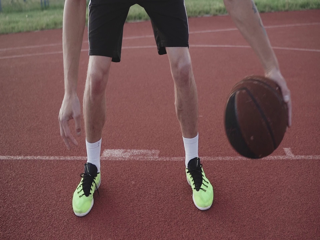

In [9]:
# ⚠️ CHANGE THIS PATH TO YOUR VIDEO! ⚠️
video_path = "/content/drive/MyDrive/Colab Notebooks/Video/basketball.mp4"

print(f"🎬 Loading video from: {video_path}")

# Check if video exists
if not os.path.exists(video_path):
    print(f"❌ Video not found at {video_path}")
    print("Please update the video_path variable above with the correct path to your video!")
    print("You can upload a video to Colab or use one from Google Drive.")
else:
    print("✅ Video found!")

# Extract the first frame
cap = cv2.VideoCapture(video_path)
ret, first_frame = cap.read()
original_first_frame = first_frame.copy()
cap.release()

if not ret:
    print("❌ Could not read video. Please check the file format.")
else:
    first_frame_rgb = cv2.cvtColor(first_frame, cv2.COLOR_BGR2RGB)
    first_frame_pil = Image.fromarray(first_frame_rgb)

    print(f"✅ Video loaded successfully!")
    print(f"   📏 Frame size: {first_frame_pil.size}")
    print(f"   🎨 Showing first frame...")

    display(first_frame_pil.resize((320, 240)))


## 🔍 Step 5: Object Detection with OWLv2

This is where the magic begins ✨  
OWLv2 detects objects directly from text descriptions.

👉 Change the `text_queries` list to detect what you need:
- `["person", "human"]`
- `["car", "vehicle"]`
- `["dog", "cat"]`
- `["ball", "football"]`


In [10]:
# 🎯 CHANGE THIS TO DETECT DIFFERENT OBJECTS! 🎯
text_queries = [["basketball", "ball"]]

print(f"🔍 Looking for: {text_queries[0]}")
print("🤖 Running OWLv2 object detection...")

inputs = owl_processor(images=first_frame_pil, text=text_queries, return_tensors="pt")
with torch.no_grad():
    outputs = owl_model(**inputs)

target_sizes = torch.tensor([[first_frame_pil.height, first_frame_pil.width]])
results = owl_processor.post_process_grounded_object_detection(
    outputs=outputs,
    target_sizes=target_sizes,
    text_labels=text_queries,
    threshold=0.2
)[0]

boxes_xyxy = [box.tolist() for box in results["boxes"]]
print(f"✅ Found {len(boxes_xyxy)} objects matching your description!")

if len(boxes_xyxy) == 0:
    print("🔍 No objects found. Trying with lower confidence threshold...")
    results = owl_processor.post_process_grounded_object_detection(
        outputs=outputs,
        target_sizes=target_sizes,
        text_labels=text_queries,
        threshold=0.1
    )[0]
    boxes_xyxy = [box.tolist() for box in results["boxes"]]
    print(f"✅ Found {len(boxes_xyxy)} objects with lower confidence!")


🔍 Looking for: ['basketball', 'ball']
🤖 Running OWLv2 object detection...
✅ Found 1 objects matching your description!


## 🎨 Step 6: Create Precise Masks with SAM2

Now we’ll generate pixel-perfect masks for each detected object.


In [11]:
print("🎨 Creating precise object masks with SAM2...")

full_mask = np.zeros((first_frame_pil.height, first_frame_pil.width), dtype=np.uint8)
sam2_predictor.set_image(first_frame_rgb)

for i, box in enumerate(boxes_xyxy):
    x0, y0, x1, y1 = map(int, box)
    print(f"🔲 Creating mask for object {i+1} at ({x0}, {y0}, {x1}, {y1})")

    masks, scores, _ = sam2_predictor.predict(box=np.array([x0, y0, x1, y1]))

    if masks is not None and len(masks) > 0:
        best_mask = masks[0].astype(np.uint8)
        box_mask = np.zeros_like(full_mask, dtype=np.uint8)
        box_mask[y0:y1, x0:x1] = 1
        clipped_mask = best_mask * box_mask
        full_mask[clipped_mask > 0] = i + 1
        print(f"✅ Added object {i+1} to tracking mask")
    else:
        print(f"⚠️ Could not create mask for object {i+1}")


🎨 Creating precise object masks with SAM2...
🔲 Creating mask for object 1 at (1344, 338, 1732, 712)
✅ Added object 1 to tracking mask


## 📊 Step 7: Visualize Detection & Segmentation

We’ll display both:
- Object detection bounding boxes  
- Segmentation masks overlay


📊 Creating visualization of detection and segmentation...


/tmp/ipython-input-4074771301.py:30: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4074771301.py:30: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


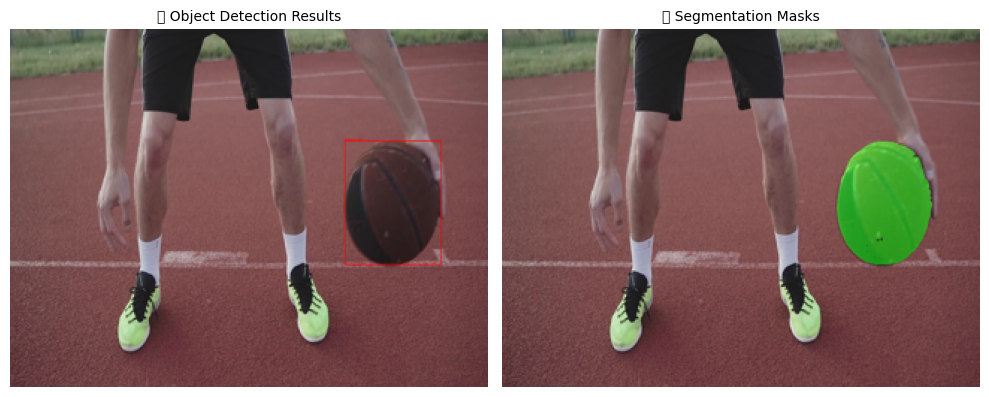

🎯 Ready to track 1 objects through the video!


In [12]:
print("📊 Creating visualization of detection and segmentation...")

drawn_image = first_frame_pil.copy()
draw = ImageDraw.Draw(drawn_image)
font = ImageFont.load_default()

for box, score, label in zip(results["boxes"], results["scores"], results["text_labels"]):
    box = [round(x.item(), 2) for x in box]
    draw.rectangle(box, outline="red", width=3)
    draw.text((box[0], box[1] - 10), f"{label}: {round(score.item(), 2)}", fill="red", font=font)

masked_image = np.array(first_frame_pil)
green_mask = np.zeros_like(masked_image)
green_mask[full_mask > 0] = [0, 255, 0]
overlayed_image = cv2.addWeighted(masked_image, 1.0, green_mask, 0.5, 0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
display_size = (320, 240)
drawn_resized = drawn_image.resize(display_size)
overlay_resized = Image.fromarray(overlayed_image).resize(display_size)

ax1.imshow(drawn_resized)
ax1.set_title("🔍 Object Detection Results", fontsize=10)
ax1.axis("off")

ax2.imshow(overlay_resized)
ax2.set_title("🎨 Segmentation Masks", fontsize=10)
ax2.axis("off")

plt.tight_layout()
plt.show()

num_objects = len(np.unique(full_mask)) - 1
print(f"🎯 Ready to track {num_objects} objects through the video!")


## 🎬 Step 8: Track Objects with Cutie

Now we track objects frame by frame using Cutie.  
This will generate a new video with tracking overlays.


🎬 Starting video tracking with Cutie...
📹 Video info: 1920x1080 at 29 FPS, 424 total frames
🚀 Initializing tracking with detected objects...


/tmp/ipython-input-2670446548.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=autocast_enabled):
/content/Cutie/cutie/utils/tensor_utils.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


📹 Processing frame 0/200


/content/Cutie/cutie/model/modules.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/content/Cutie/cutie/model/transformer/object_summarizer.py:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


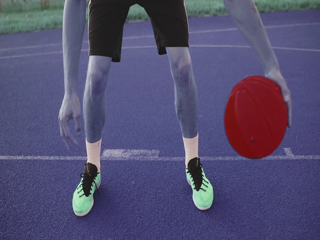

/content/Cutie/cutie/model/big_modules.py:289: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/content/Cutie/cutie/model/modules.py:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


📹 Processing frame 20/200


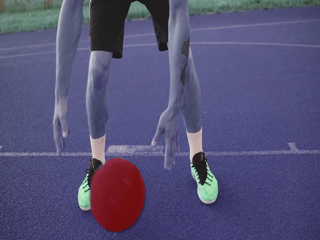

📹 Processing frame 40/200


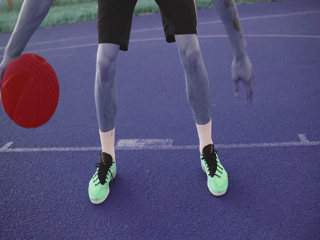

📹 Processing frame 60/200


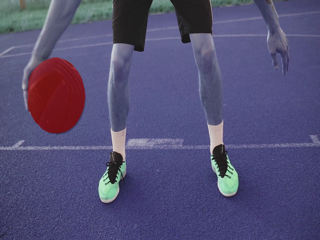

📹 Processing frame 80/200


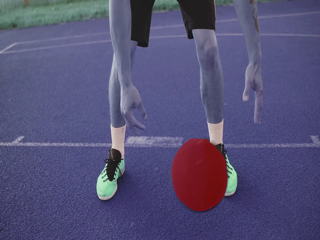

📹 Processing frame 100/200


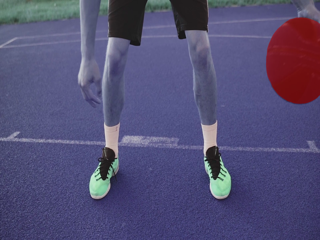

📹 Processing frame 120/200


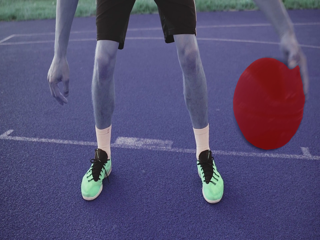

📹 Processing frame 140/200


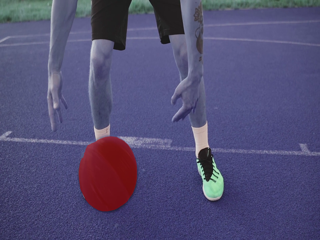

📹 Processing frame 160/200


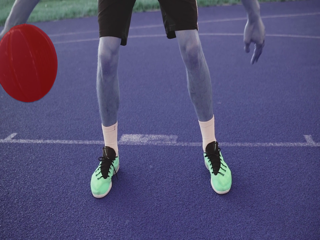

📹 Processing frame 180/200


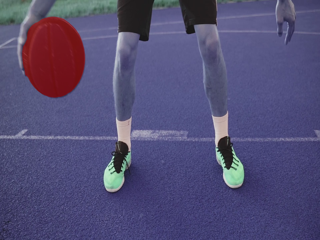

🎉 Video tracking completed!
📊 Processed 200 frames
💾 Saved output video to: /content/tracked_video.mp4


In [13]:
print("🎬 Starting video tracking with Cutie...")

if num_objects == 0:
    print("❌ No objects detected to track. Please check your detection settings.")
else:
    if use_cuda:
        torch.cuda.empty_cache()

    processor = InferenceCore(cutie, cfg=cfg)
    cap = cv2.VideoCapture(video_path)

    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    print(f"📹 Video info: {width}x{height} at {fps} FPS, {total_frames} total frames")

    frames_to_process = min(200, total_frames)
    display_every = 20

    output_path = "/content/tracked_video.mp4"
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    current_frame = 0
    tracked_frames = []
    original_frames = []

    with torch.inference_mode():
        autocast_enabled = use_cuda

        with torch.cuda.amp.autocast(enabled=autocast_enabled):
            while cap.isOpened() and current_frame < frames_to_process:
                ret, frame = cap.read()
                if not ret:
                    break

                original_frames.append(frame.copy())
                frame_torch = image_to_torch(frame, device=device)

                if current_frame == 0:
                    print("🚀 Initializing tracking with detected objects...")
                    mask_torch = index_numpy_to_one_hot_torch(full_mask, num_objects + 1).to(device)
                    prediction = processor.step(frame_torch, mask_torch[1:], idx_mask=False)
                else:
                    prediction = processor.step(frame_torch)

                prediction_np = torch_prob_to_numpy_mask(prediction)
                visualization = overlay_davis(frame, prediction_np)

                out.write(cv2.cvtColor(visualization, cv2.COLOR_RGB2BGR))

                if current_frame % display_every == 0:
                    print(f"📹 Processing frame {current_frame}/{frames_to_process}")
                    vis_pil = Image.fromarray(visualization).resize((320, 240))
                    display(vis_pil)

                tracked_frames.append(visualization)
                current_frame += 1

    cap.release()
    out.release()

    print(f"🎉 Video tracking completed!")
    print(f"📊 Processed {current_frame} frames")
    print(f"💾 Saved output video to: {output_path}")


## 📺 Step 9: Compare Original vs Tracked

We’ll visualize the first and last frames of the original and tracked video.


🖼️ Frame Comparison: First vs Last (Original vs Tracked)


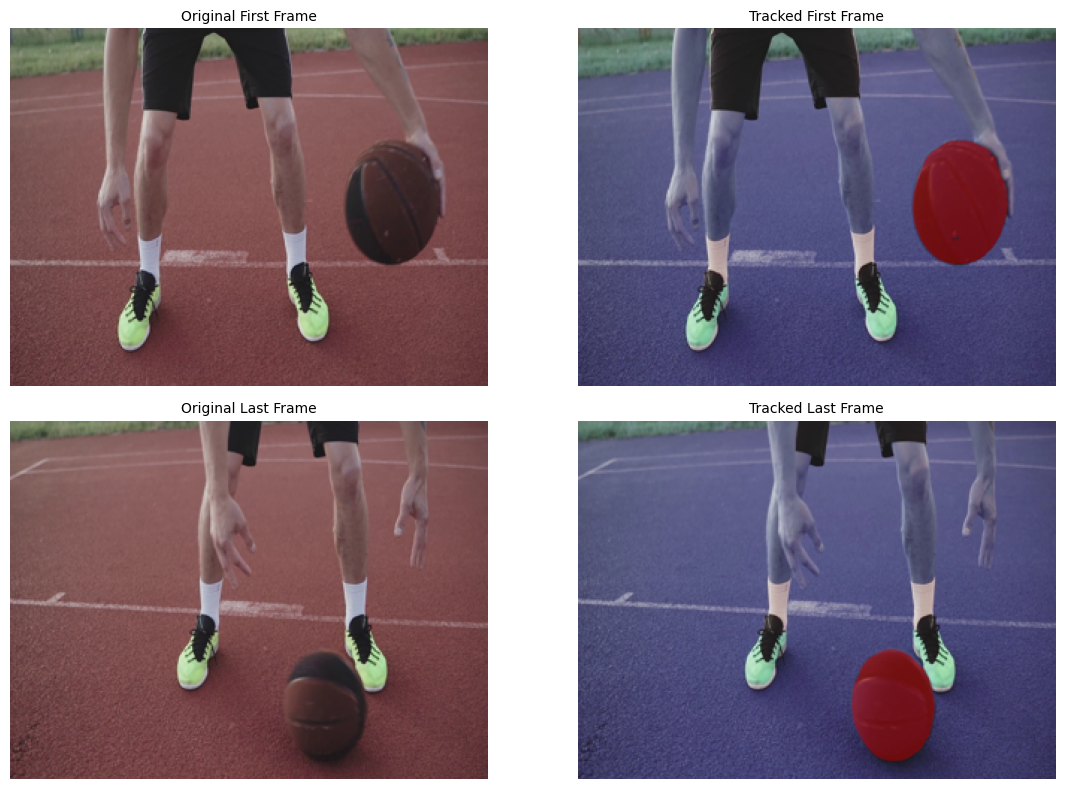


📹 Video Results:
🎥 Original Video:


🎯 Tracked Video:


In [14]:
if len(tracked_frames) > 0 and len(original_frames) > 0:
    print("🖼️ Frame Comparison: First vs Last (Original vs Tracked)")

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    orig_first_rgb = cv2.cvtColor(original_frames[0], cv2.COLOR_BGR2RGB)
    orig_last_rgb = cv2.cvtColor(original_frames[-1], cv2.COLOR_BGR2RGB)

    display_size = (320, 240)
    orig_first_resized = Image.fromarray(orig_first_rgb).resize(display_size)
    tracked_first_resized = Image.fromarray(tracked_frames[0]).resize(display_size)
    orig_last_resized = Image.fromarray(orig_last_rgb).resize(display_size)
    tracked_last_resized = Image.fromarray(tracked_frames[-1]).resize(display_size)

    axes[0,0].imshow(orig_first_resized)
    axes[0,0].set_title("Original First Frame", fontsize=10)
    axes[0,0].axis("off")

    axes[0,1].imshow(tracked_first_resized)
    axes[0,1].set_title("Tracked First Frame", fontsize=10)
    axes[0,1].axis("off")

    axes[1,0].imshow(orig_last_resized)
    axes[1,0].set_title("Original Last Frame", fontsize=10)
    axes[1,0].axis("off")

    axes[1,1].imshow(tracked_last_resized)
    axes[1,1].set_title("Tracked Last Frame", fontsize=10)
    axes[1,1].axis("off")

    plt.tight_layout()
    plt.show()

    print("\n📹 Video Results:")
    print("🎥 Original Video:")
    display(Video(video_path, width=400, height=300))

    print("🎯 Tracked Video:")
    display(Video(output_path, width=400, height=300))


## 📋 Final Summary

✅ Detected objects using **OWLv2** (text-prompt based detection)  
✅ Created precise segmentation masks with **SAM2**  
✅ Tracked objects across video frames using **Cutie**  
✅ Combined all three models into a **single pipeline**  
✅ Produced a processed video with tracked objects  

---

### 🚀 Key Takeaways
- You can **track any object** in video just by describing it in natural language  
- The combination of **detection + segmentation + tracking** makes it robust against occlusion and motion  
- This workflow can be extended to **sports analytics, surveillance, autonomous driving, and video editing**   
